# Christoffel Symbols: A Computational Introduction

## 1. Introduction

**Christoffel symbols** are fundamental objects in differential geometry that describe how basis vectors change from point to point in a curved space. They are essential for understanding geodesics, parallel transport, and the geometry of curved manifolds. Named after Elwin Bruno Christoffel (1829–1900), these symbols provide the connection coefficients needed to define covariant derivatives.

In general relativity, Christoffel symbols encode the gravitational field and determine how freely falling particles move through spacetime.

## 2. Mathematical Foundation

### 2.1 The Metric Tensor

Consider a manifold $\mathcal{M}$ with coordinates $x^\mu$ (where $\mu = 0, 1, 2, \ldots, n-1$). The **metric tensor** $g_{\mu\nu}$ defines the geometry of the manifold through the line element:

$$ds^2 = g_{\mu\nu} \, dx^\mu \, dx^\nu$$

The metric tensor is symmetric: $g_{\mu\nu} = g_{\nu\mu}$.

### 2.2 Definition of Christoffel Symbols

The **Christoffel symbols of the second kind** are defined as:

$$\Gamma^\lambda_{\mu\nu} = \frac{1}{2} g^{\lambda\sigma} \left( \frac{\partial g_{\sigma\mu}}{\partial x^\nu} + \frac{\partial g_{\sigma\nu}}{\partial x^\mu} - \frac{\partial g_{\mu\nu}}{\partial x^\sigma} \right)$$

where $g^{\lambda\sigma}$ is the inverse metric tensor satisfying $g^{\lambda\sigma} g_{\sigma\nu} = \delta^\lambda_\nu$.

The **Christoffel symbols of the first kind** are:

$$\Gamma_{\lambda\mu\nu} = \frac{1}{2} \left( \frac{\partial g_{\lambda\mu}}{\partial x^\nu} + \frac{\partial g_{\lambda\nu}}{\partial x^\mu} - \frac{\partial g_{\mu\nu}}{\partial x^\lambda} \right)$$

They are related by: $\Gamma^\lambda_{\mu\nu} = g^{\lambda\sigma} \Gamma_{\sigma\mu\nu}$

### 2.3 Key Properties

1. **Symmetry in lower indices**: $\Gamma^\lambda_{\mu\nu} = \Gamma^\lambda_{\nu\mu}$ (for torsion-free connections)

2. **Number of independent components**: For an $n$-dimensional space, there are $\frac{n^2(n+1)}{2}$ independent Christoffel symbols.

3. **Not a tensor**: Christoffel symbols do not transform as tensors under coordinate transformations.

### 2.4 The Covariant Derivative

The covariant derivative of a vector $V^\mu$ is:

$$\nabla_\nu V^\mu = \frac{\partial V^\mu}{\partial x^\nu} + \Gamma^\mu_{\nu\lambda} V^\lambda$$

For a covector $W_\mu$:

$$\nabla_\nu W_\mu = \frac{\partial W_\mu}{\partial x^\nu} - \Gamma^\lambda_{\nu\mu} W_\lambda$$

### 2.5 Geodesic Equation

The geodesic equation, describing the path of a freely falling particle, is:

$$\frac{d^2 x^\mu}{d\tau^2} + \Gamma^\mu_{\alpha\beta} \frac{dx^\alpha}{d\tau} \frac{dx^\beta}{d\tau} = 0$$

where $\tau$ is an affine parameter (proper time for massive particles).

## 3. Computational Implementation

We will implement a general-purpose calculator for Christoffel symbols and apply it to several important examples:

1. **2D Polar Coordinates** (flat space in curvilinear coordinates)
2. **Spherical Surface** (2D curved space embedded in 3D)
3. **Schwarzschild Metric** (spacetime around a black hole)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

print("Libraries loaded successfully.")

Libraries loaded successfully.


### 3.1 General Christoffel Symbol Calculator

We implement a numerical calculator that computes Christoffel symbols from a metric tensor using finite differences.

In [2]:
def compute_christoffel_symbols(metric_func, coords, h=1e-6):
    """
    Compute Christoffel symbols numerically for a given metric.
    
    Parameters:
    -----------
    metric_func : callable
        Function that returns the metric tensor g_ij at given coordinates.
        Should return an n x n numpy array.
    coords : array-like
        Coordinates at which to evaluate the Christoffel symbols.
    h : float
        Step size for numerical differentiation.
    
    Returns:
    --------
    gamma : ndarray
        Christoffel symbols Gamma^lambda_{mu nu} as a 3D array.
        gamma[lambda, mu, nu] gives the symbol.
    """
    coords = np.array(coords, dtype=float)
    n = len(coords)
    
    # Get the metric at the point
    g = metric_func(coords)
    
    # Compute inverse metric
    g_inv = np.linalg.inv(g)
    
    # Compute partial derivatives of the metric
    dg = np.zeros((n, n, n))  # dg[sigma, mu, nu] = d(g_mu_nu)/d(x^sigma)
    
    for sigma in range(n):
        coords_plus = coords.copy()
        coords_minus = coords.copy()
        coords_plus[sigma] += h
        coords_minus[sigma] -= h
        
        g_plus = metric_func(coords_plus)
        g_minus = metric_func(coords_minus)
        
        dg[sigma] = (g_plus - g_minus) / (2 * h)
    
    # Compute Christoffel symbols of the first kind
    # Gamma_{lambda, mu, nu} = (1/2)(dg_{lambda mu}/dx^nu + dg_{lambda nu}/dx^mu - dg_{mu nu}/dx^lambda)
    gamma_first = np.zeros((n, n, n))
    
    for lam in range(n):
        for mu in range(n):
            for nu in range(n):
                gamma_first[lam, mu, nu] = 0.5 * (
                    dg[nu, lam, mu] + dg[mu, lam, nu] - dg[lam, mu, nu]
                )
    
    # Raise the first index to get Christoffel symbols of the second kind
    # Gamma^lambda_{mu nu} = g^{lambda sigma} Gamma_{sigma, mu, nu}
    gamma = np.zeros((n, n, n))
    
    for lam in range(n):
        for mu in range(n):
            for nu in range(n):
                for sigma in range(n):
                    gamma[lam, mu, nu] += g_inv[lam, sigma] * gamma_first[sigma, mu, nu]
    
    return gamma


def print_christoffel_symbols(gamma, coord_names, threshold=1e-10):
    """
    Print non-zero Christoffel symbols in a readable format.
    """
    n = gamma.shape[0]
    print("Non-zero Christoffel symbols (second kind):")
    print("=" * 50)
    
    found = False
    for lam in range(n):
        for mu in range(n):
            for nu in range(mu, n):  # Exploit symmetry
                val = gamma[lam, mu, nu]
                if abs(val) > threshold:
                    found = True
                    print(f"Γ^{coord_names[lam]}_{{{coord_names[mu]}{coord_names[nu]}}} = {val:.6f}")
    
    if not found:
        print("All Christoffel symbols are zero (flat space in Cartesian coordinates).")
    print()

print("Christoffel symbol calculator defined.")

Christoffel symbol calculator defined.


### 3.2 Example 1: 2D Polar Coordinates

For 2D polar coordinates $(r, \theta)$, the metric is:

$$ds^2 = dr^2 + r^2 d\theta^2$$

The metric tensor is:
$$g_{\mu\nu} = \begin{pmatrix} 1 & 0 \\ 0 & r^2 \end{pmatrix}$$

The analytical Christoffel symbols are:
- $\Gamma^r_{\theta\theta} = -r$
- $\Gamma^\theta_{r\theta} = \Gamma^\theta_{\theta r} = \frac{1}{r}$

In [3]:
def polar_metric(coords):
    """
    Metric tensor for 2D polar coordinates.
    coords = [r, theta]
    """
    r, theta = coords
    return np.array([
        [1, 0],
        [0, r**2]
    ])

# Compute at r = 2, theta = pi/4
r_val, theta_val = 2.0, np.pi/4
gamma_polar = compute_christoffel_symbols(polar_metric, [r_val, theta_val])

print(f"Polar coordinates at r = {r_val}, θ = {theta_val:.4f}")
print_christoffel_symbols(gamma_polar, ['r', 'θ'])

# Verify analytically
print("Analytical values:")
print(f"Γ^r_{{θθ}} = -r = {-r_val:.6f}")
print(f"Γ^θ_{{rθ}} = 1/r = {1/r_val:.6f}")

Polar coordinates at r = 2.0, θ = 0.7854
Non-zero Christoffel symbols (second kind):
Γ^r_{θθ} = -2.000000
Γ^θ_{rθ} = 0.500000

Analytical values:
Γ^r_{θθ} = -r = -2.000000
Γ^θ_{rθ} = 1/r = 0.500000


### 3.3 Example 2: Spherical Surface (2-Sphere)

For a sphere of radius $R$ with coordinates $(\theta, \phi)$ (colatitude and azimuth), the metric is:

$$ds^2 = R^2 d\theta^2 + R^2 \sin^2\theta \, d\phi^2$$

The metric tensor is:
$$g_{\mu\nu} = \begin{pmatrix} R^2 & 0 \\ 0 & R^2\sin^2\theta \end{pmatrix}$$

The analytical Christoffel symbols are:
- $\Gamma^\theta_{\phi\phi} = -\sin\theta \cos\theta$
- $\Gamma^\phi_{\theta\phi} = \Gamma^\phi_{\phi\theta} = \cot\theta$

In [4]:
def sphere_metric(coords, R=1.0):
    """
    Metric tensor for a 2-sphere of radius R.
    coords = [theta, phi] (colatitude, azimuth)
    """
    theta, phi = coords
    return np.array([
        [R**2, 0],
        [0, R**2 * np.sin(theta)**2]
    ])

# Compute at theta = pi/3, phi = pi/6
theta_s, phi_s = np.pi/3, np.pi/6
gamma_sphere = compute_christoffel_symbols(sphere_metric, [theta_s, phi_s])

print(f"Spherical surface at θ = {theta_s:.4f}, φ = {phi_s:.4f}")
print_christoffel_symbols(gamma_sphere, ['θ', 'φ'])

# Verify analytically
print("Analytical values:")
print(f"Γ^θ_{{φφ}} = -sin(θ)cos(θ) = {-np.sin(theta_s)*np.cos(theta_s):.6f}")
print(f"Γ^φ_{{θφ}} = cot(θ) = {1/np.tan(theta_s):.6f}")

Spherical surface at θ = 1.0472, φ = 0.5236
Non-zero Christoffel symbols (second kind):
Γ^θ_{φφ} = -0.433013
Γ^φ_{θφ} = 0.577350

Analytical values:
Γ^θ_{φφ} = -sin(θ)cos(θ) = -0.433013
Γ^φ_{θφ} = cot(θ) = 0.577350


### 3.4 Example 3: Schwarzschild Metric

The Schwarzschild metric describes spacetime outside a spherically symmetric, non-rotating mass $M$:

$$ds^2 = -\left(1 - \frac{r_s}{r}\right)c^2 dt^2 + \left(1 - \frac{r_s}{r}\right)^{-1} dr^2 + r^2 d\theta^2 + r^2 \sin^2\theta \, d\phi^2$$

where $r_s = \frac{2GM}{c^2}$ is the Schwarzschild radius.

In natural units ($c = G = 1$, $r_s = 2M$), at the equatorial plane ($\theta = \pi/2$), the metric reduces to:

$$g_{\mu\nu} = \begin{pmatrix} -(1-2M/r) & 0 & 0 & 0 \\ 0 & (1-2M/r)^{-1} & 0 & 0 \\ 0 & 0 & r^2 & 0 \\ 0 & 0 & 0 & r^2 \end{pmatrix}$$

In [5]:
def schwarzschild_metric(coords, M=1.0):
    """
    Schwarzschild metric in natural units (G = c = 1).
    coords = [t, r, theta, phi]
    """
    t, r, theta, phi = coords
    rs = 2 * M  # Schwarzschild radius
    
    if r <= rs:
        raise ValueError("r must be greater than the Schwarzschild radius")
    
    f = 1 - rs / r
    
    return np.array([
        [-f, 0, 0, 0],
        [0, 1/f, 0, 0],
        [0, 0, r**2, 0],
        [0, 0, 0, r**2 * np.sin(theta)**2]
    ])

# Compute at r = 10M, theta = pi/2 (equatorial plane), t = 0, phi = 0
M = 1.0
r_sch = 10.0  # In units of M
coords_sch = [0.0, r_sch, np.pi/2, 0.0]

gamma_sch = compute_christoffel_symbols(
    lambda c: schwarzschild_metric(c, M), 
    coords_sch
)

print(f"Schwarzschild metric at r = {r_sch}M, θ = π/2")
print_christoffel_symbols(gamma_sch, ['t', 'r', 'θ', 'φ'])

Schwarzschild metric at r = 10.0M, θ = π/2
Non-zero Christoffel symbols (second kind):
Γ^t_{tr} = 0.012500
Γ^r_{tt} = 0.008000
Γ^r_{rr} = -0.012500
Γ^r_{θθ} = -8.000000
Γ^r_{φφ} = -8.000000
Γ^θ_{rθ} = 0.100000
Γ^φ_{rφ} = 0.100000



## 4. Geodesics on a Sphere

We will now visualize geodesics (great circles) on a sphere using the geodesic equation with Christoffel symbols.

In [6]:
def geodesic_equations_sphere(y, s, R=1.0):
    """
    Geodesic equations for a sphere.
    y = [theta, phi, dtheta/ds, dphi/ds]
    
    The equations are:
    d²θ/ds² + Γ^θ_{φφ} (dφ/ds)² = 0
    d²φ/ds² + 2 Γ^φ_{θφ} (dθ/ds)(dφ/ds) = 0
    """
    theta, phi, dtheta, dphi = y
    
    # Avoid singularity at poles
    theta = np.clip(theta, 0.01, np.pi - 0.01)
    
    # Christoffel symbols for sphere
    Gamma_theta_phiphi = -np.sin(theta) * np.cos(theta)
    Gamma_phi_thetaphi = np.cos(theta) / np.sin(theta)  # cot(theta)
    
    # Geodesic equations
    d2theta = -Gamma_theta_phiphi * dphi**2
    d2phi = -2 * Gamma_phi_thetaphi * dtheta * dphi
    
    return [dtheta, dphi, d2theta, d2phi]


def spherical_to_cartesian(theta, phi, R=1.0):
    """Convert spherical to Cartesian coordinates."""
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    return x, y, z


# Generate multiple geodesics with different initial conditions
s = np.linspace(0, 2*np.pi, 500)

# Initial conditions: [theta, phi, dtheta/ds, dphi/ds]
initial_conditions = [
    [np.pi/2, 0, 0, 1],           # Equator
    [np.pi/4, 0, 0.5, 0.5],       # Tilted geodesic 1
    [np.pi/3, np.pi/4, 0.7, 0.3], # Tilted geodesic 2
    [np.pi/2, np.pi, 0.8, 0.2],   # Tilted geodesic 3
]

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
labels = ['Equator', 'Geodesic 1', 'Geodesic 2', 'Geodesic 3']

print("Computing geodesics on the sphere...")

Computing geodesics on the sphere...


Figure saved to plot.png


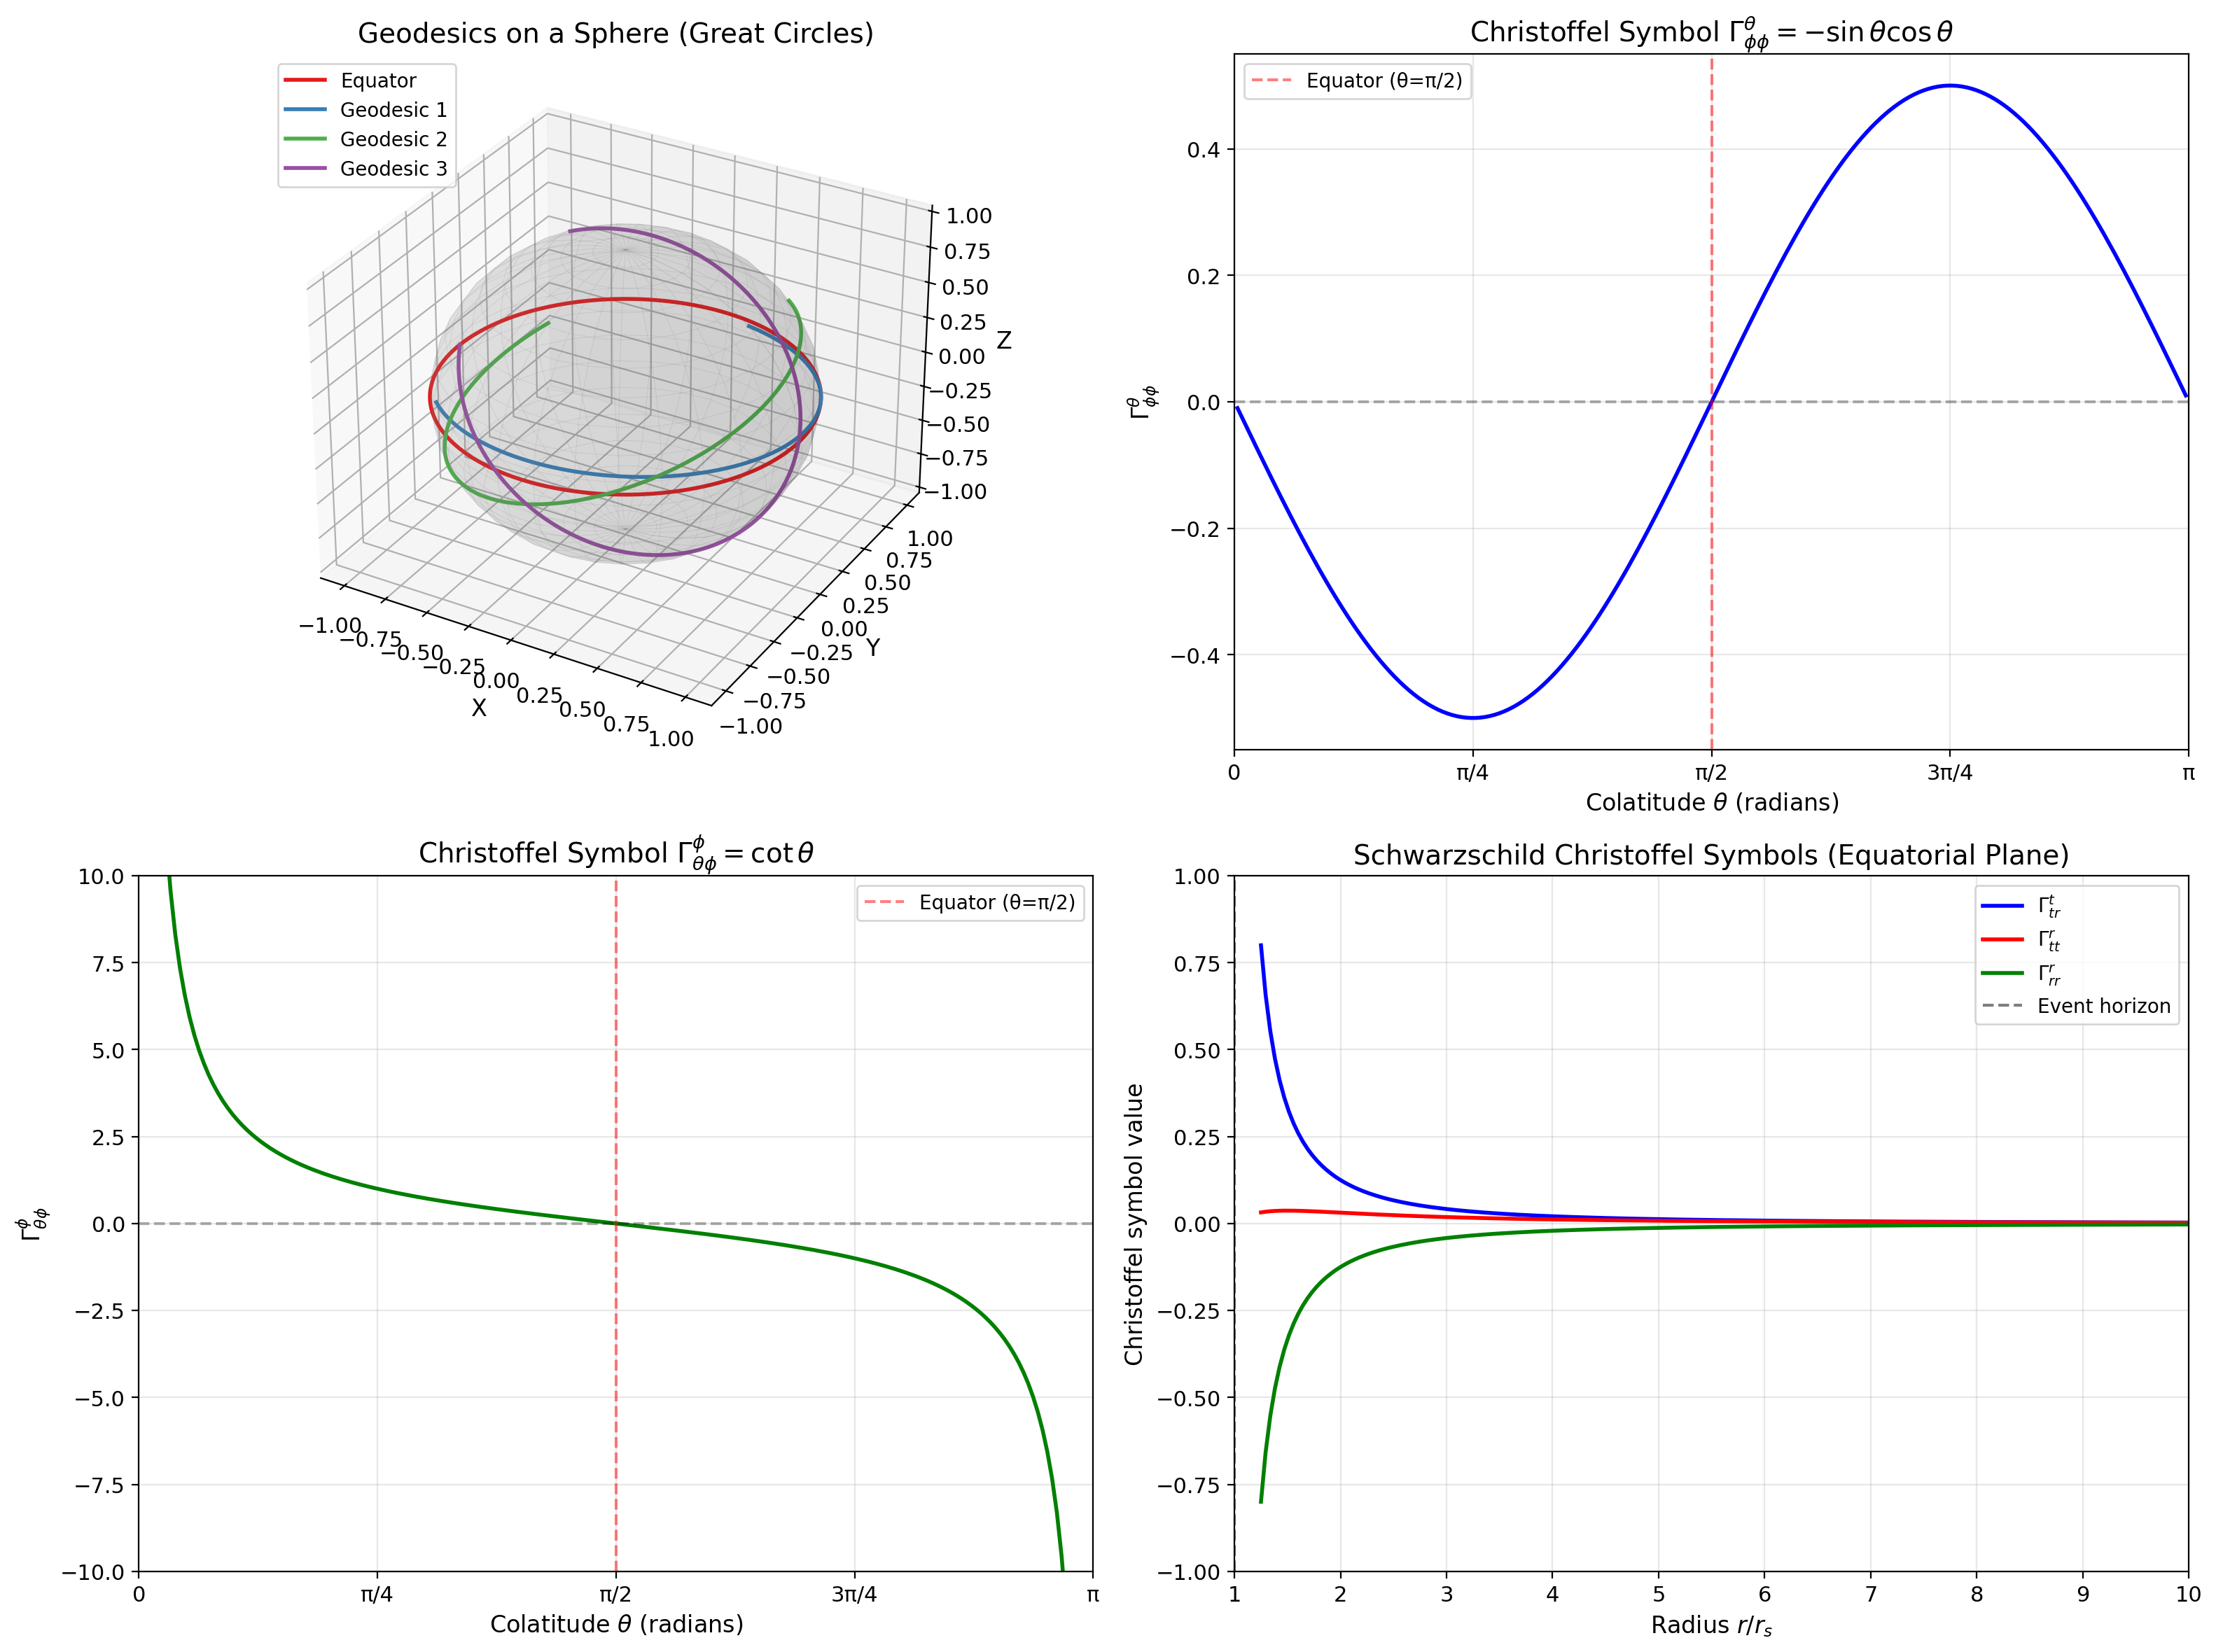

In [7]:
# Create the figure
fig = plt.figure(figsize=(16, 12))

# ============================================
# Panel 1: 3D Sphere with Geodesics
# ============================================
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

# Draw sphere wireframe
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 20)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

ax1.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.1, color='gray')
ax1.plot_wireframe(x_sphere, y_sphere, z_sphere, alpha=0.2, color='gray', linewidth=0.3)

# Plot geodesics
for i, ic in enumerate(initial_conditions):
    sol = odeint(geodesic_equations_sphere, ic, s)
    theta_geo, phi_geo = sol[:, 0], sol[:, 1]
    x_geo, y_geo, z_geo = spherical_to_cartesian(theta_geo, phi_geo)
    ax1.plot(x_geo, y_geo, z_geo, color=colors[i], linewidth=2, label=labels[i])

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Geodesics on a Sphere (Great Circles)')
ax1.legend(loc='upper left')

# ============================================
# Panel 2: Christoffel Symbol Γ^θ_{φφ} on Sphere
# ============================================
ax2 = fig.add_subplot(2, 2, 2)

theta_range = np.linspace(0.01, np.pi - 0.01, 200)
gamma_theta_phiphi = -np.sin(theta_range) * np.cos(theta_range)

ax2.plot(theta_range, gamma_theta_phiphi, 'b-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=np.pi/2, color='r', linestyle='--', alpha=0.5, label='Equator (θ=π/2)')

ax2.set_xlabel(r'Colatitude $\theta$ (radians)')
ax2.set_ylabel(r'$\Gamma^\theta_{\phi\phi}$')
ax2.set_title(r'Christoffel Symbol $\Gamma^\theta_{\phi\phi} = -\sin\theta\cos\theta$')
ax2.set_xlim(0, np.pi)
ax2.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax2.set_xticklabels(['0', 'π/4', 'π/2', '3π/4', 'π'])
ax2.legend()
ax2.grid(True, alpha=0.3)

# ============================================
# Panel 3: Christoffel Symbol Γ^φ_{θφ} on Sphere
# ============================================
ax3 = fig.add_subplot(2, 2, 3)

gamma_phi_thetaphi = 1 / np.tan(theta_range)  # cot(theta)

ax3.plot(theta_range, gamma_phi_thetaphi, 'g-', linewidth=2)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.axvline(x=np.pi/2, color='r', linestyle='--', alpha=0.5, label='Equator (θ=π/2)')

ax3.set_xlabel(r'Colatitude $\theta$ (radians)')
ax3.set_ylabel(r'$\Gamma^\phi_{\theta\phi}$')
ax3.set_title(r'Christoffel Symbol $\Gamma^\phi_{\theta\phi} = \cot\theta$')
ax3.set_xlim(0, np.pi)
ax3.set_ylim(-10, 10)
ax3.set_xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax3.set_xticklabels(['0', 'π/4', 'π/2', '3π/4', 'π'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# ============================================
# Panel 4: Schwarzschild Christoffel Symbols vs Radius
# ============================================
ax4 = fig.add_subplot(2, 2, 4)

r_range = np.linspace(2.5, 20, 200)  # Start outside event horizon (r_s = 2M)
M = 1.0
rs = 2 * M

# Key Christoffel symbols for Schwarzschild at equatorial plane
# Γ^t_{tr} = M / (r(r - 2M))
gamma_t_tr = M / (r_range * (r_range - rs))

# Γ^r_{tt} = M(r - 2M) / r³
gamma_r_tt = M * (r_range - rs) / r_range**3

# Γ^r_{rr} = -M / (r(r - 2M))
gamma_r_rr = -M / (r_range * (r_range - rs))

# Γ^r_{θθ} = -(r - 2M)
gamma_r_thetatheta = -(r_range - rs)

ax4.plot(r_range / rs, gamma_t_tr, 'b-', linewidth=2, label=r'$\Gamma^t_{tr}$')
ax4.plot(r_range / rs, gamma_r_tt, 'r-', linewidth=2, label=r'$\Gamma^r_{tt}$')
ax4.plot(r_range / rs, gamma_r_rr, 'g-', linewidth=2, label=r'$\Gamma^r_{rr}$')

ax4.axvline(x=1, color='k', linestyle='--', alpha=0.5, label='Event horizon')
ax4.set_xlabel(r'Radius $r/r_s$')
ax4.set_ylabel('Christoffel symbol value')
ax4.set_title('Schwarzschild Christoffel Symbols (Equatorial Plane)')
ax4.set_xlim(1, 10)
ax4.set_ylim(-1, 1)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
plt.savefig('christoffel_symbols_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
print("Figure saved to plot.png")

plt.show()

## 5. Discussion

### 5.1 Physical Interpretation

The Christoffel symbols encode how the coordinate basis vectors twist and turn as we move through the manifold:

1. **Polar Coordinates**: The non-zero $\Gamma^r_{\theta\theta} = -r$ tells us that motion in the $\theta$ direction (at constant $r$) experiences an apparent "centrifugal" acceleration in the negative $r$ direction—this is why circular motion requires a centripetal force.

2. **Sphere**: The symbol $\Gamma^\theta_{\phi\phi}$ vanishes at the equator ($\theta = \pi/2$) and is maximal at mid-latitudes. This explains why great circles that start along the equator stay on the equator, while those starting at other latitudes oscillate in $\theta$.

3. **Schwarzschild Metric**: The divergence of certain Christoffel symbols near the event horizon ($r \to r_s$) reflects the extreme spacetime curvature. The symbol $\Gamma^r_{tt}$ relates to gravitational acceleration—it approaches $M/r^2$ far from the black hole, recovering Newtonian gravity.

### 5.2 Relation to Curvature

While Christoffel symbols themselves are not tensors, they are used to construct the Riemann curvature tensor:

$$R^\rho_{\sigma\mu\nu} = \partial_\mu \Gamma^\rho_{\nu\sigma} - \partial_\nu \Gamma^\rho_{\mu\sigma} + \Gamma^\rho_{\mu\lambda} \Gamma^\lambda_{\nu\sigma} - \Gamma^\rho_{\nu\lambda} \Gamma^\lambda_{\mu\sigma}$$

The Riemann tensor genuinely measures curvature and transforms as a tensor.

### 5.3 Numerical Considerations

Our numerical implementation uses finite differences, which introduces small errors. For high-precision applications:

- Use symbolic computation (e.g., SymPy) for exact analytical results
- Employ adaptive step sizes for better accuracy
- Be careful near coordinate singularities (poles, event horizons)

## 6. Summary

We have explored Christoffel symbols through:

1. **Mathematical definition** from the metric tensor
2. **Numerical computation** using finite differences
3. **Three examples**: polar coordinates, spherical surface, and Schwarzschild spacetime
4. **Geodesic visualization** on the sphere

Christoffel symbols are the bridge between the metric (which encodes geometry) and the equations of motion (geodesics). They are indispensable tools in differential geometry and general relativity.

## References

1. Carroll, S. M. (2004). *Spacetime and Geometry: An Introduction to General Relativity*. Addison-Wesley.

2. Misner, C. W., Thorne, K. S., & Wheeler, J. A. (1973). *Gravitation*. W. H. Freeman.

3. Wald, R. M. (1984). *General Relativity*. University of Chicago Press.

4. do Carmo, M. P. (1992). *Riemannian Geometry*. Birkhäuser.